#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

#### parameters to set

In [2]:
n_series = 6
n_timesteps = 8*24*3600 # 8 days

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

#### generate normal data

In [3]:
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df[s]=pd.Series(v)
df['Flag']=0
#df.head()

#### generate anomalies

In [4]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = (n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    for s in affects:
        df.loc[start:end,s] = df.loc[start:end,s] + random.random() * 0.3
    if len(affects)>1:
        df.loc[start:end,"Flag"]=1
        

#### enforce range

In [5]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

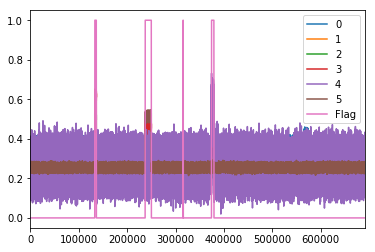

In [6]:
df.plot()
#print df[147599]

#### running BDT

In [14]:
# clf = AdaBoostClassifier(n_estimators=100)
# y=df.Flag
# X=df.loc[:,range(n_series)]
# scores = cross_val_score(clf, X, y)
# print(scores)
predicted_flag_array = np.zeros((24*3600,), dtype=np.int)
print predicted_flag_array

[0 0 0 ..., 0 0 0]


#### Train a model for all hours after the first day

In [15]:
#separate data into Reference and Subject
def trainer(reference, subject):
    refTrainSize = (int)(reference.shape[0] * 0.7) #training size of reference data is 70% of the data
    subTrainSize = (int)(subject.shape[0] * 0.7) #training size of subject data is 70% of the data
    print ("refTrainSize: ", refTrainSize, "subTrainSize: ", subTrainSize)
    print ("reference.shape: ", reference.shape, "subject.shape: ", subject.shape)
    reference.loc[:].Flag = 0 # Flagging the reference data as 0
    X_ref = reference.loc[:, range(n_series)] #refers to the feature set data
    y_ref = reference.Flag #refers to the label data
    
    print ("X_ref.shape: ", X_ref.shape, "y_ref.shape: ", y_ref.shape)
    
    subject.loc[:].Flag = 1 # Flagging the subject data as 1
    X_sub = subject.loc[:, range(n_series)] #refers to the feature set data
    y_sub = subject.Flag #refers to the label data
    
    print ("X_sub.shape: ", X_sub.shape, "y_sub.shape: ", y_sub.shape)
    
    #n = n+hour
    #if(n+hour <= n_timesteps):
    #    n = n+hour

    #separate Reference into Train and Test
    X_ref_train = X_ref.loc[:refTrainSize, range(n_series)] #take 70% of the reference feature data
    X_ref_test  = X_ref.loc[refTrainSize:, range(n_series)] #take 30% of the reference feature data
    y_ref_train = y_ref.loc[:refTrainSize] #take 70% of the reference label data
    y_ref_test  = y_ref.loc[refTrainSize:] #take 30% of the reference label data

    #separate Subject into Train and Test
    X_sub_train = X_sub.loc[:subTrainSize, range(n_series)] #take 70% of the subject feature data
    X_sub_test  = X_sub.loc[subTrainSize:, range(n_series)] #take 30% of the subject feature data
    y_sub_train = y_sub.loc[:subTrainSize] #take 70% of the subject label data
    y_sub_test  = y_sub.loc[subTrainSize:] #take 30% of the subject label data

    #Combine reference and subject train datasets
    X_train_frames = [X_ref_train, X_sub_train] 
    print ("X_ref_train.shape: ", X_ref_train.shape, "X_sub_train.shape: ", X_sub_train.shape)
    X_train = pd.concat(X_train_frames, ignore_index=True) #combine the 70% training data features from both reference and subject
    
    y_train_frames = [y_ref_train, y_sub_train]
    print ("y_ref_train.shape: ", y_ref_train.shape, "y_sub_train.shape: ", y_sub_train.shape)
    y_train = pd.concat(y_train_frames, ignore_index=True) #combine the 70% training data label from both reference and subject

    #Combine reference and subject test datasets
    X_test_frames = [X_ref_test, X_sub_test]
    print ("X_ref_test.shape: ", X_ref_test.shape, "X_sub_test.shape: ", X_sub_test.shape)
    X_test = pd.concat(X_test_frames, ignore_index=True) #combine the 30% training data features from both reference and subject
    
    y_test_frames = [y_ref_test, y_sub_test]
    print ("y_ref_test.shape: ", y_ref_test.shape, "y_sub_test.shape: ", y_sub_test.shape)
    y_test = pd.concat(y_test_frames, ignore_index=True) #combine the 30% training data label from both reference and subject

    #Train model using the combined train data
    clf = AdaBoostClassifier(n_estimators=100)
    print ("X_train.shape: ", X_train.shape, "Y_train.shape: ", y_train.shape)
    clf.fit(X_train, y_train) 
    #train an AdaBoost model to be able to tell the difference between the reference and subject data

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    #use the trained AdaBoost model on the testing data. This is the predicted result
        
    from sklearn.metrics import roc_curve, auc
        
    #Calculate the AUC
        
    #from sklearn.preprocessing import LabelBinarizer

    # convert False and True to 0 and 1
    #lb = LabelBinarizer()
    #y_test_transformed = lb.fit_transform(y_test)
    #y_predict_transformed = lb.fit_transform(y_predict)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    #if (auc_score != 0.5):
    #    auc_score = 1.0
    print auc_score #finds the auc score. If auc~.5, then no anomalies. If auc>0.5, then there are anomalies

    return y_predict

#### Calculate AUC

In [16]:
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

n = 24*3600 # n_timesteps/8
m = 0
k = 0
hour = 3600
while(n+m <= n_timesteps):
    ref = df[m:n] #reference data refers to the data collected from the first day
    ref_reset_index = ref.reset_index(drop=True)
    
    sub = df[n:n+hour] #subject data refers to the data collected from the last hour
    sub_reset_index = sub.reset_index(drop=True)
    
    y_predict = trainer(ref_reset_index, sub_reset_index)
    np.append(predicted_flag_array, y_predict)

    m = m + hour
    n = n + hour
    k = k + 1
        
# convert False and True to 0 and 1
#lb = LabelBinarizer()
#y_test_transformed = lb.fit_transform(y_test)
#y_predict_transformed = lb.fit_transform(y_predict)
#fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
#auc_score = auc(fpr, tpr) #calculate the AUC score
#print auc_score #finds the auc score. If auc~.5, then no anomalies. If auc>0.5, then there are anomalies

('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 6))
('y_ref_test.shape: ', (25921,), 'y_sub_test.shape: ', (1080,))
('X_train.shape: ', (63001, 6), 'Y_train.shape: ', (63001,))
0.499942131862
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 6))


0.499961421241
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 6))
('y_ref_test.shape: ', (25921,), 'y_sub_test.shape: ', (1080,))
('X_train.shape: ', (63001, 6), 'Y_train.shape: ', (63001,))
0.499903553104
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape:

0.499903553104
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 6))
('y_ref_test.shape: ', (25921,), 'y_sub_test.shape: ', (1080,))
('X_train.shape: ', (63001, 6), 'Y_train.shape: ', (63001,))
0.499961421241
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape:

0.285251340612
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 6))
('y_ref_test.shape: ', (25921,), 'y_sub_test.shape: ', (1080,))
('X_train.shape: ', (63001, 6), 'Y_train.shape: ', (63001,))
0.5
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 

0.499980710621
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 6))
('y_ref_test.shape: ', (25921,), 'y_sub_test.shape: ', (1080,))
('X_train.shape: ', (63001, 6), 'Y_train.shape: ', (63001,))
0.5
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 

0.499961421241
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape: ', (1080, 6))
('y_ref_test.shape: ', (25921,), 'y_sub_test.shape: ', (1080,))
('X_train.shape: ', (63001, 6), 'Y_train.shape: ', (63001,))
0.499961421241
('refTrainSize: ', 60479, 'subTrainSize: ', 2520)
('reference.shape: ', (86400, 7), 'subject.shape: ', (3600, 7))
('X_ref.shape: ', (86400, 6), 'y_ref.shape: ', (86400,))
('X_sub.shape: ', (3600, 6), 'y_sub.shape: ', (3600,))
('X_ref_train.shape: ', (60480, 6), 'X_sub_train.shape: ', (2521, 6))
('y_ref_train.shape: ', (60480,), 'y_sub_train.shape: ', (2521,))
('X_ref_test.shape: ', (25921, 6), 'X_sub_test.shape:

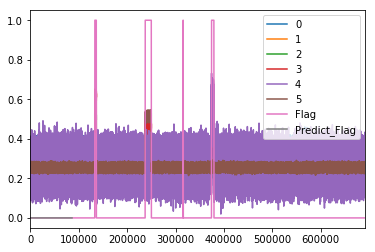

In [17]:
#X=df.loc[:,range(n_series)] # get all the features
#y_predict = clf.predict(X)  # predict whole list of Flags
y_predict_df = pd.DataFrame(predicted_flag_array[0:n_timesteps], columns=['Predict_Flag']) #label my predicted anomalies
# X_test_reset_index = X_test.reset_index(drop=True)
x_y_combined = pd.concat([df, y_predict_df], axis=1) #append the column to the right of the original table
x_y_combined.plot()

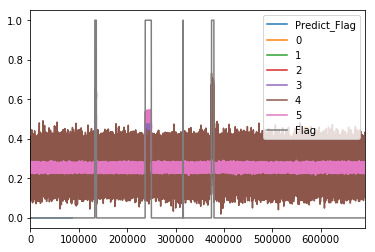

In [18]:
x_y_combined2 = pd.concat([y_predict_df, df], axis=1) #append the column to the right of the original table
x_y_combined2.plot()